## Shock evolution in non-radiative supernova remnants

Code adapated from Tang&Chevalier, 2016 to describe the evolution of the shock radius and shock speed as a function of time. These solutions are similar to the Truelove&McKee, 1999 solutions but they provide a better accuracy when compared with hydro numerical simulations in particular in the case for s=2 and high ejecta index.


In [6]:
%matplotlib inline
#%matplotlib notebook

# futur division is very important for exponent: 1/2 = 0.5 and not 0
from __future__ import  division, print_function
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from astropy import units as u
from ipywidgets.widgets.interaction import interact, fixed
from scipy import interpolate

def tang_evol(Tsnr,Mej=1, E51snr=1, n0=1, Rdensity=9.6,n=9,s=2):
    """
    Tang&Chevalier2016 equations for s=0 or s=2. Simpler and better precision than TM99 for s=2.
    Equations return the radius and Vsh  (by deriving t(R)) for a
    a given Mejecta, E51snr, upstream density, ejecta slope (n) and
    homogeneous ambient medium (s=0) or wind progenitor (s=2).
    
    Inputs:
    Tsnr: array (or scalar) of age of the SNR in yrs
    Mej: ejecta mass in solar mass
    E51snr: explosion energy in 10**51 ergs
    n0: density in cm-3
    Rdensity: normalization for the case s=2 for n0 at a given density
    n: slope in the ejecta
    s: 0/2 for homogenous medium/wind progenitor.
       for s=2, the density is given at a certain radius Rdensity (pc)
    
    Outputs:
    Rb  : Array of blast wave radius in pc
    Vsh : Array of shock speed in km/s
    
    F. Acero, August 2016
    
    """


    #tch is in yr and Rch in pc
    #Vsh will therefore be in pc/yr
    if s == 2:
        tch=5633*E51snr**(-1/2.)*Mej**(3/2)*(n0*Rdensity**2)**(-1) #*3.15e7  # Eq A3 from Laming 2003, page 358
        Rch=40.74*(Mej)*(n0*Rdensity**2)**(-1)  #         # Eq A4 from Laming03
        ksi= 3/(2*np.pi)
        mydict={6:(3.8,0.77),7:(2.9,0.83),8:(2.3,0.90),9:(2.0,0.97),
                10:(1.7,1.03),12:(1.5,1.14),14:(1.34,1.23)}

    if s == 0:
        tch=473.6*E51snr**(-1/2.)*Mej**(5/6)*n0**(-1/3) # Eq A1 from Laming 2003, page 357. Corrected by Hwang12, Eq A1
        Rch=3.43*(Mej)**(1./3.)*(n0)**(-1/3)          # Eq A2 from Laming 2003, page 357.Corrected by Hwang12, Eq A2
        ksi=2.026
        mydict={6:(8.5,1.05),7:(4.5,1.06),8:(3.6,1.08),9:(2.7,1.12),
                10:(2.3,1.15),12:(1.9,1.21),14:(1.7,1.26)}

    if  isinstance(Tsnr, np.ndarray) == False:
        t = np.array([Tsnr])/tch
    else:
        t = Tsnr/tch


    alpha, zeta = mydict[n]
    expo1=2*alpha*(n-s)/(n-3)
    expo2=1/(2*alpha)
    
    #Tang relations give an analytical expression for t(R) not for R(t) which would not be analytical 
    R_ = np.logspace(np.log10(1e-5),np.log10(1e2),num=1000) #intermediate radius expression
    t_ = ( (R_/zeta)**expo1 + (R_**(5-s)/ksi)**alpha  )**expo2 
    
    factor = (5-s)/(2*ksi**alpha)*R_**((5-s)*alpha-1) + 1/zeta*(n-s)/(n-3)*(R_/zeta)**(expo1-1)
    v_ = t_**(2*alpha-1)/factor

        #Interpolating for R and V at the times Tsnr given in input
    f_R = interpolate.interp1d(t_, R_) # reversing order from t(R) to R(t)
    f_V = interpolate.interp1d(t_, v_)

    
    try:
        Rpc=f_R(t)*Rch *u.parsec
        Vsh=(f_V(t)*Rch/tch * u.parsec/u.year).to('km/s')
        m = f_V(t) * t / f_R(t)
    except:
        print('Error: requested T is outside temporary t array')
        print('t_, t min: %s %s'%(np.min(t_),np.min(t)) )
        print('t_, t max: %s %s'%(np.max(t_),np.max(t)) )
        raise

    return Rpc, Vsh, m
    
  

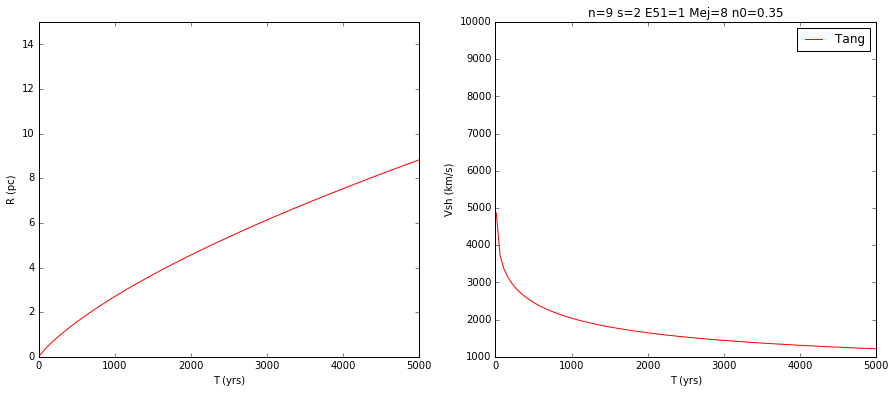

In [13]:
Tsnr=np.linspace(10,5e3,num=100)

def plot_R_V(Mej,E51snr,n0,n,s):
    Rdensity=9.6 # in pc
    fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1,figsize=(15,6))

    R,Vsh,m = tang_evol(Tsnr,Mej=Mej, E51snr=E51snr, n0=n0, Rdensity=Rdensity,n=n,s=s) #Mej, E51snr, n0, Rsnr, T

    ax1.plot(Tsnr,R,color='red',label='Tang')
    ax2.plot(Tsnr,Vsh,color='red',label='Tang')
    ax1.set_ylim(0,15)
    ax2.set_ylim(1e3,10e3)

    ax2.set_title('n=%i s=%i E51=%i Mej=%i n0=%.2f'%(n,s,E51snr,Mej,n0))
    ax1.set_ylabel('R (pc)')
    ax2.set_ylabel('Vsh (km/s)')

    ax1.set_xlabel('T (yrs)')
    ax2.set_xlabel('T (yrs)')
    plt.legend()
    plt.show()


interact(plot_R_V,Mej=(4,14,2),E51snr=(0.6,1.6,0.2),n0=(0.01,0.7,0.02),n=(6,12),s=[0,2,2])
